In [1]:
import umap
import numpy as np
import numpy.linalg as la
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import math
#Fashion mnist
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST
%notebook

UsageError: the following arguments are required: filename


In [2]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


In [3]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## Control embedding 
The following embedding represents the control embedding for the fashion MNIST. rotational invariance over this data would translate to a perfect rotation across the entire embedding. For now all embedding will be done in two dimensions to expedite embedding comparison 


In [4]:
neighbors=15
dim=2
epochs=500
dist=.2

In [5]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_control_2d = reducer.fit_transform(data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Tue Sep 13 09:39:48 2022 Construct fuzzy simplicial set
Tue Sep 13 09:39:49 2022 Finding Nearest Neighbors
Tue Sep 13 09:39:49 2022 Building RP forest with 18 trees
Tue Sep 13 09:39:50 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Tue Sep 13 09:40:03 2022 Finished Nearest Neighbor Search
Tue Sep 13 09:40:06 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Sep 13 09:41:54 2022 Finished embedding


In [6]:
type(embedding_control_2d)

numpy.ndarray

<IPython.core.display.Javascript object>


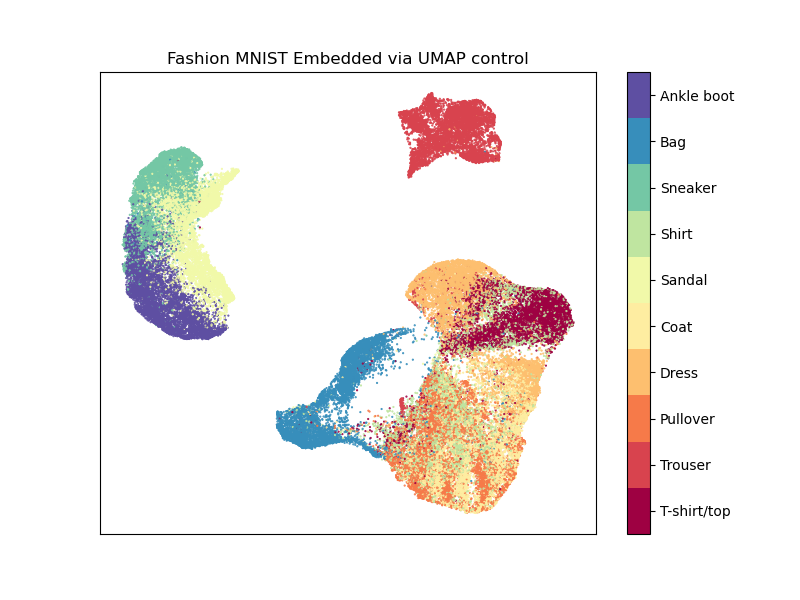

In [52]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');

In [56]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=3, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_control_3d = reducer.fit_transform(data)

UMAP(min_dist=0.2, n_components=3, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 10:31:03 2022 Construct fuzzy simplicial set
Wed Sep  7 10:31:03 2022 Finding Nearest Neighbors
Wed Sep  7 10:31:03 2022 Building RP forest with 18 trees
Wed Sep  7 10:31:04 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 10:31:07 2022 Finished Nearest Neighbor Search
Wed Sep  7 10:31:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 10:33:04 2022 Finished embedding


In [3]:
def rotate(theta,image):
    
    theta=math.radians(theta)                               #converting degrees to radians
    cosine=math.cos(theta)
    sine=math.sin(theta)
                                 
    
    # Compute augmented image dimensions
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    #init temp matrix to be populated with individually rotated elements
    output=np.zeros((new_height,new_width))
    # Identify point of rotation in original image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(theta,x,y)
            #Adjust coordinates to be relative to the new center after rotation
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    """
    #trim output: 
    # iterate through matrix, if there exists an element less than tau round it down to 0
    tau=.1
    for j in range(output.shape[0]):
        for k in range(output.shape[0]):
            if output[j][k]<tau:
                output[j][k]=np.rint(output[j][k])
    # identify indices of zero rows and columns and delete them from the final matrix( could be done with less lines )
    idx = np.argwhere(np.all(output[..., :] == 0, axis=0))
    o2 = np.delete(output, idx, axis=0)
    idy = np.argwhere(np.all(output[..., :] == 0, axis=1))
    o3= np.delete(o2, idy, axis=1)
    return o3           
    """
    return output

In [ ]:
# Experimental trimming model for later on trim each image to its minimum dim then pad each photo to have the same size 

In [4]:
# A shear is used here to avoid issues with anti aliasing, method described by 
#vhttps://www.ocf.berkeley.edu/~fricke/projects/israel/paeth/rotation_by_shearing.html
def shear(angle,x,y):
    '''
    |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
    |0      1     |  |sin(𝜃)   1|  |0      1     |
    '''
    
    tangent=math.tan(angle/2)
    new_x=round(x-y*tangent)
    new_y=y
    
    new_y=round(new_x*math.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix
    new_x=round(new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix
    
    return new_y,new_x

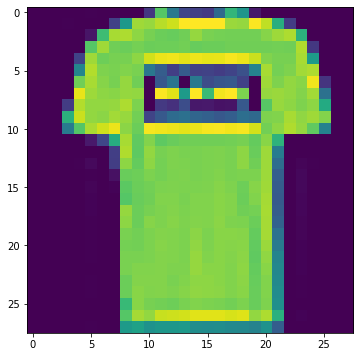

(41, 41)
(41, 41)


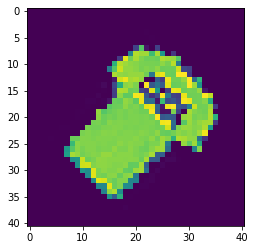

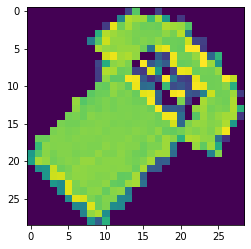

(29, 29)


In [94]:
#testing rotations on sample image 


l=np.reshape(data[1],(28,28))
fig = plt.figure( figsize=(8, 6))
plt.imshow(l, cmap='viridis')
plt.show()

#fails for 5,6 degrees for some reason, debugging needed 
i=rotate(45,l)
print(i.shape)

plt.imshow(i, cmap='viridis')
plt.show()

print(i3.shape)

## Rotational experiments
Please note that for the figures below, the embeddings were originally generated on a version of rotate() that did not preform an image trimming step. Later experiments demonstrate that this does not effect the final embedding as far as I can tell, however it is important to keep this in mind as it may be a reason for descrepancies between embeddings 

## Rotating 45 degrees

In [95]:
#rotating all of the data by 45deg
theta=45
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r45_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r45_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [96]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r45 = reducer.fit_transform(r45_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Thu Sep  8 09:27:08 2022 Construct fuzzy simplicial set
Thu Sep  8 09:27:08 2022 Finding Nearest Neighbors
Thu Sep  8 09:27:09 2022 Building RP forest with 18 trees
Thu Sep  8 09:27:11 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Sep  8 09:27:23 2022 Finished Nearest Neighbor Search
Thu Sep  8 09:27:26 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Sep  8 09:29:14 2022 Finished embedding


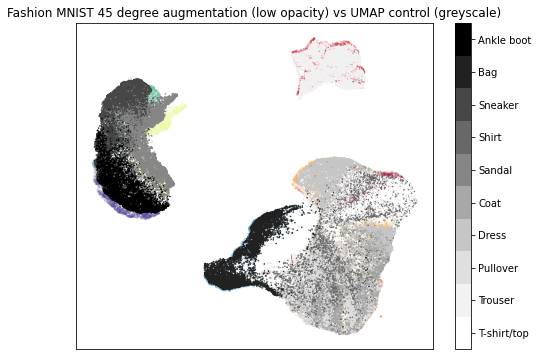

In [36]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding_r45.T, s=0.3, c=target, cmap='Spectral', alpha=.2)
plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 45 degree augmentation (low opacity) vs UMAP control (greyscale)');

## Rotating 30 degrees

In [12]:
#rotating all of the data by 30deg
theta=30
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r30_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r30_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [11]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r30 = reducer.fit_transform(r30_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 08:45:16 2022 Construct fuzzy simplicial set
Wed Sep  7 08:45:16 2022 Finding Nearest Neighbors
Wed Sep  7 08:45:16 2022 Building RP forest with 18 trees
Wed Sep  7 08:45:18 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 08:45:25 2022 Finished Nearest Neighbor Search
Wed Sep  7 08:45:28 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 08:47:16 2022 Finished embedding


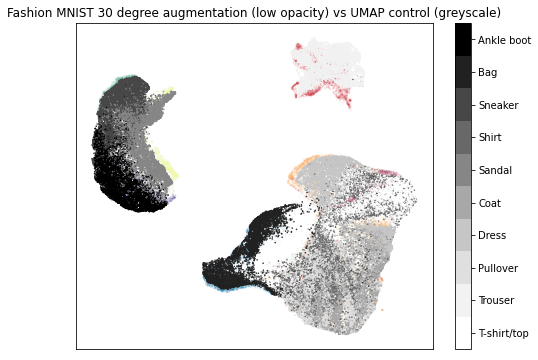

In [38]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding_r30.T, s=0.3, c=target, cmap='Spectral', alpha=.1)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 30 degree augmentation (low opacity) vs UMAP control (greyscale)');

## Rotating 150 degrees

In [21]:
#rotating all of the data by 150deg
theta=150
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r150_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r150_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [22]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r150 = reducer.fit_transform(r150_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:20:42 2022 Construct fuzzy simplicial set
Wed Sep  7 09:20:43 2022 Finding Nearest Neighbors
Wed Sep  7 09:20:43 2022 Building RP forest with 18 trees
Wed Sep  7 09:20:45 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:20:47 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:20:48 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:22:39 2022 Finished embedding


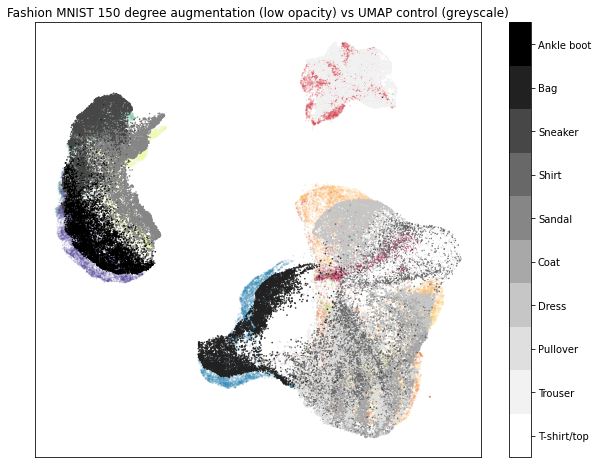

In [39]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_r150.T, s=0.3, c=target, cmap='Spectral', alpha=.2)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 150 degree augmentation (low opacity) vs UMAP control (greyscale)');

## Rotating 200 degrees

In [11]:
#rotating all of the data by 200deg
theta=200
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r200_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r200_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [31]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r200 = reducer.fit_transform(r200_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:38:27 2022 Construct fuzzy simplicial set
Wed Sep  7 09:38:27 2022 Finding Nearest Neighbors
Wed Sep  7 09:38:27 2022 Building RP forest with 18 trees
Wed Sep  7 09:38:29 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:38:32 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:38:32 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:40:19 2022 Finished embedding


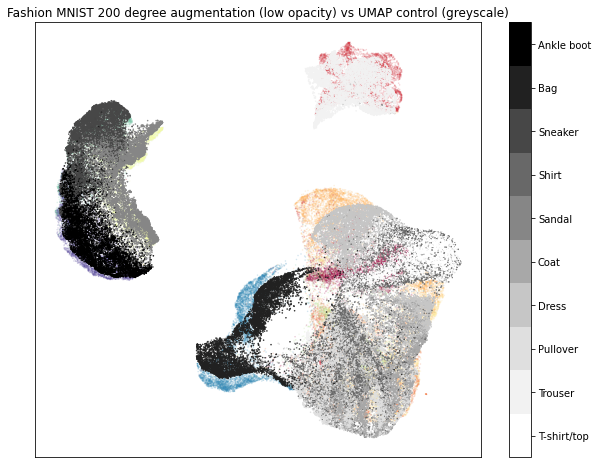

In [35]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_r200.T, s=0.3, c=target, cmap='Spectral', alpha=.2)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 200 degree augmentation (low opacity) vs UMAP control (greyscale)');

# Notably worse invariance on high rotation degree

## Rotating 280 degrees 

In [42]:
#rotating all of the data by 200deg
theta=280
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r280_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r280_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [43]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r280 = reducer.fit_transform(r280_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:49:24 2022 Construct fuzzy simplicial set
Wed Sep  7 09:49:24 2022 Finding Nearest Neighbors
Wed Sep  7 09:49:24 2022 Building RP forest with 18 trees
Wed Sep  7 09:49:25 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:49:28 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:49:28 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:51:14 2022 Finished embedding


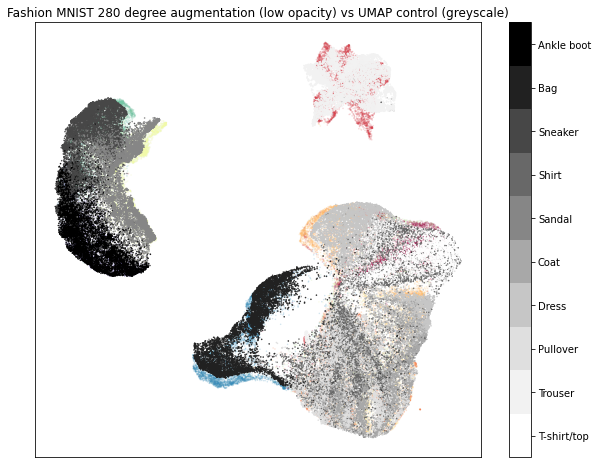

In [44]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_r280.T, s=0.3, c=target, cmap='Spectral', alpha=.2)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 280 degree augmentation (low opacity) vs UMAP control (greyscale)');

In [45]:
## Rotating 90 degrees

In [47]:
#rotating all of the data by 200deg
theta=90
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r90_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r90_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [48]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r90 = reducer.fit_transform(r90_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:57:25 2022 Construct fuzzy simplicial set
Wed Sep  7 09:57:26 2022 Finding Nearest Neighbors
Wed Sep  7 09:57:26 2022 Building RP forest with 18 trees
Wed Sep  7 09:57:27 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:57:29 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:57:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:59:18 2022 Finished embedding


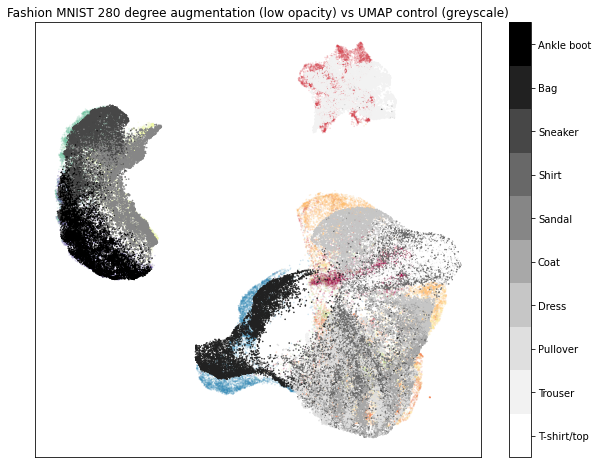

In [49]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_r90.T, s=0.3, c=target, cmap='Spectral', alpha=.2)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 280 degree augmentation (low opacity) vs UMAP control (greyscale)');

In [50]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=3, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r90_3d = reducer.fit_transform(r90_data)

UMAP(min_dist=0.2, n_components=3, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:59:47 2022 Construct fuzzy simplicial set
Wed Sep  7 09:59:47 2022 Finding Nearest Neighbors
Wed Sep  7 09:59:47 2022 Building RP forest with 18 trees
Wed Sep  7 09:59:48 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:59:51 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:59:51 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 10:01:47 2022 Finished embedding


<IPython.core.display.Javascript object>


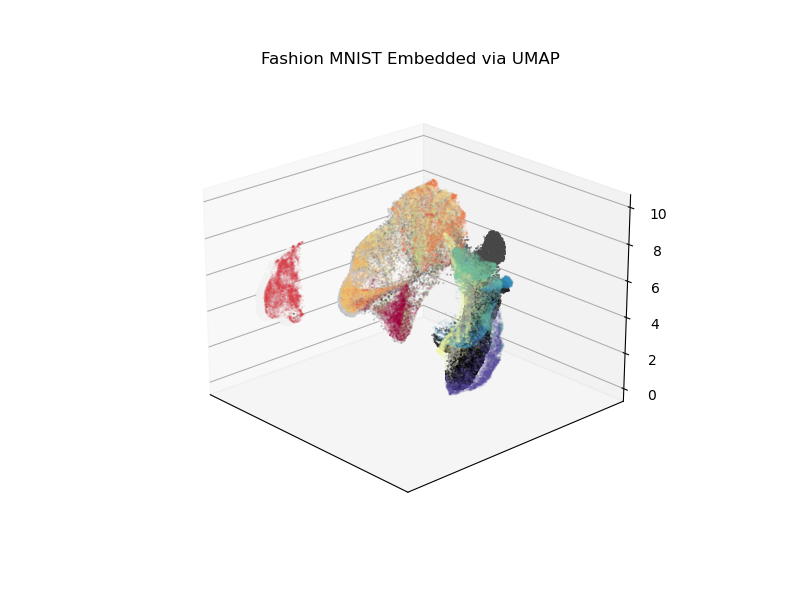

In [57]:
%matplotlib notebook

fig = plt.figure( figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*embedding_control_3d.T, c=target, s=.2,cmap='Greys')
ax.scatter(*embedding_r90_3d.T, c=target, s=.2,cmap='Spectral',alpha=.1)
#plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])

plt.title('Fashion MNIST Embedded via UMAP');

## Experiment 9/8/22: Trimming augmented images
Perhaps the reason that the embedding differs from the control is due to the fact that the rotated images are not trimmed. The extra vectors with a norm very close to zero may be influencing the perplexity measure at a given vertex in the fuzzy set during the construction of the simplical complex. I have modified the rotation algorithm to include a tertiary step that rounds down columns and rows with very small sums and then deletes them from the matrix. 

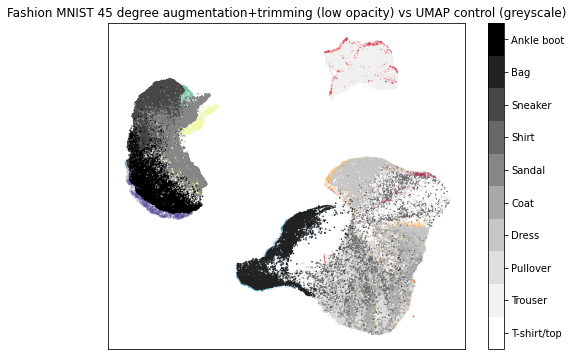

In [100]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding_r45.T, s=0.3, c=target, cmap='Spectral', alpha=.2)
plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 45 degree augmentation+trimming (low opacity) vs UMAP control (greyscale)');

It appears that with trimming or without trimming you recieve the same embedding with similar discrepancies meaning that the trimming is not needed, I will leave it in anyways to save a small amount of time on the construction of the zero matrix when building the data set prior to embedding 

## Comparing Simplical complex structure between embeddings

## Control network: 

In [7]:
import umap.plot
reducer_control = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_control_2d = reducer.fit(data)# note we are using umap.UMAP.fit() instead of umap.UMAP.fit_transform!!!!!!



UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Tue Sep 13 09:49:21 2022 Construct fuzzy simplicial set
Tue Sep 13 09:49:21 2022 Finding Nearest Neighbors
Tue Sep 13 09:49:21 2022 Building RP forest with 18 trees
Tue Sep 13 09:49:22 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Tue Sep 13 09:49:25 2022 Finished Nearest Neighbor Search
Tue Sep 13 09:49:25 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Sep 13 09:51:12 2022 Finished embedding


In [8]:
type(embedding_control_2d)

umap.umap_.UMAP

Note: connectivity plotting takes a very very long time, for the future cuda may be entirely necessary considering the computational cost associated. Currently the hammer network is taking somewhere from 2-x hours embedding terminated for the time being 

In [113]:
umap.plot.connectivity(embedding_control_2d, edge_bundling='hammer')

/home/921642160/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/umap/plot.py:885: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(

KeyboardInterrupt



<AxesSubplot:>

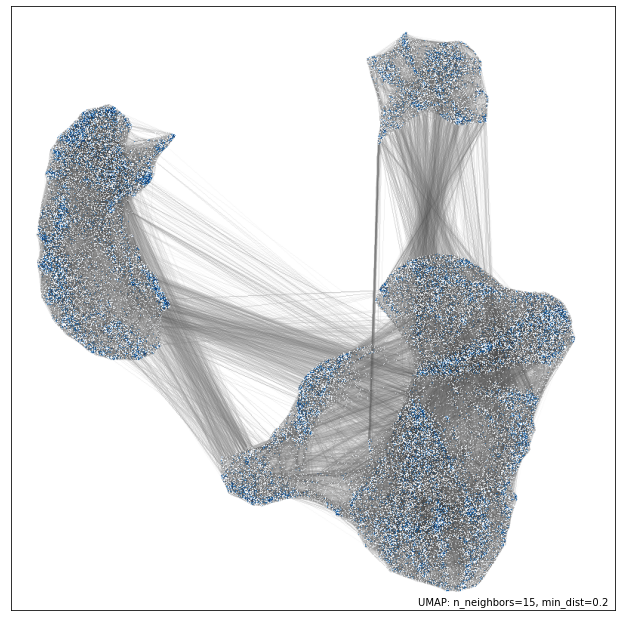

In [114]:
umap.plot.connectivity(embedding_control_2d, show_points=True)

In [117]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r200 = reducer.fit(r200_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Thu Sep  8 10:35:24 2022 Construct fuzzy simplicial set
Thu Sep  8 10:35:24 2022 Finding Nearest Neighbors
Thu Sep  8 10:35:25 2022 Building RP forest with 18 trees
Thu Sep  8 10:35:26 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Sep  8 10:35:29 2022 Finished Nearest Neighbor Search
Thu Sep  8 10:35:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Sep  8 10:37:16 2022 Finished embedding


<AxesSubplot:>

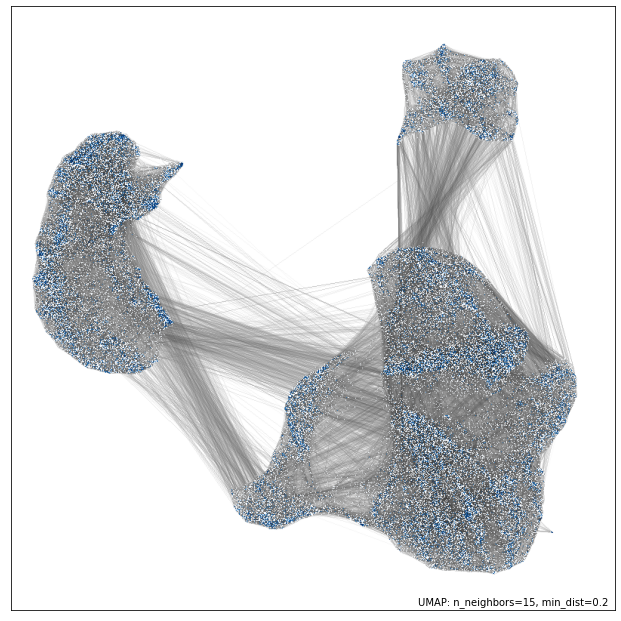

In [118]:
umap.plot.connectivity(embedding_r200, show_points=True)

This experiment demonstrates that the internal connectivity of the simplicial complex in higher dimensions is fundementally different for augmented data, abiet somewhat small differences.  referring to the the top left corner of both diagrams it can be seen that there are additoinal edge connections in the rotated embedding that are not visible in the control This may be due to the fact that when augmenting points in high dimension the corresponding result may lay close enough to be considered a neightbor during the construction of the simplical complex. 

Future work will  now be studying the resulting simplicial complex of other embeddings. This will be done with a batched algorithm that computes the overlayed embedding and complex for each rotation of the form : 
    $$0 <\frac{k\pi}{6}<2\pi\quad k \in \mathbb{Z} $$

## Principal Component Analysis 

In [7]:
import umap.plot
reducer_control = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_control_2d = reducer_control.fit(data)# note we are using umap.UMAP.fit() instead of umap.UMAP.fit_transform!!!!!!



UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Mon Sep 12 08:09:56 2022 Construct fuzzy simplicial set
Mon Sep 12 08:09:56 2022 Finding Nearest Neighbors
Mon Sep 12 08:09:56 2022 Building RP forest with 18 trees
Mon Sep 12 08:09:57 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Mon Sep 12 08:10:10 2022 Finished Nearest Neighbor Search
Mon Sep 12 08:10:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Sep 12 08:12:00 2022 Finished embedding


<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

<Figure size 576x432 with 0 Axes>

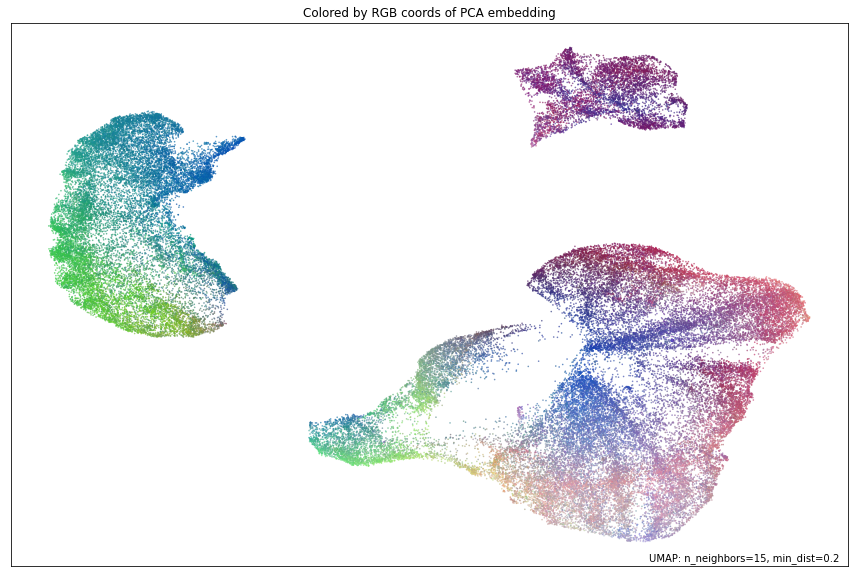

In [14]:
plt.rcParams['figure.figsize'] = (15, 10)
fig = plt.figure( figsize=(8, 6))
umap.plot.diagnostic(embedding_control_2d, diagnostic_type='pca')


In [15]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r200 = reducer.fit(r200_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Mon Sep 12 08:15:55 2022 Construct fuzzy simplicial set
Mon Sep 12 08:15:56 2022 Finding Nearest Neighbors
Mon Sep 12 08:15:56 2022 Building RP forest with 18 trees
Mon Sep 12 08:15:57 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Mon Sep 12 08:16:00 2022 Finished Nearest Neighbor Search
Mon Sep 12 08:16:01 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Sep 12 08:17:47 2022 Finished embedding


<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

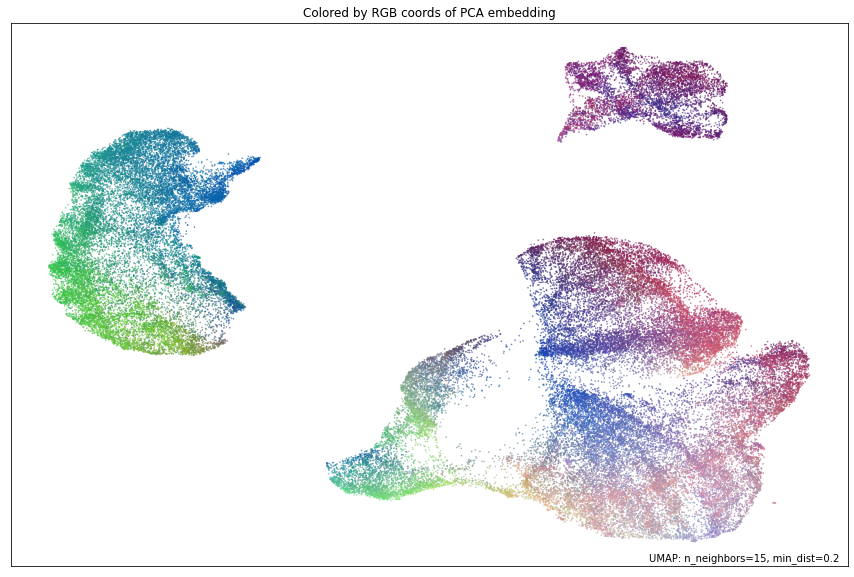

In [17]:
umap.plot.diagnostic(embedding_r200, diagnostic_type='pca')

Mon Sep 12 08:19:58 2022 Worst tree score: 0.63642857
Mon Sep 12 08:19:58 2022 Mean tree score: 0.64839444
Mon Sep 12 08:19:58 2022 Best tree score: 0.65650000
Mon Sep 12 08:20:01 2022 Forward diversification reduced edges from 1050000 to 352033
Mon Sep 12 08:20:03 2022 Reverse diversification reduced edges from 352033 to 352033
Mon Sep 12 08:20:05 2022 Degree pruning reduced edges from 386758 to 386226
Mon Sep 12 08:20:05 2022 Resorting data and graph based on tree order
Mon Sep 12 08:20:05 2022 Building and compiling search function


/home/921642160/anaconda3/envs/rapids-22.08/lib/python3.9/site-packages/umap/plot.py:203: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_nhood_compare" failed type inference due to: No implementation of function Function(<function hstack at 0x7f25dc4c7940>) found for signature:
 
 >>> hstack(list(array(int32, 1d, C))<iv=None>)
 
There are 4 candidate implementations:
  - Of which 4 did not match due to:
  Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba/core/overload_glue.py: Line 131.
    With argument(s): '(list(array(int32, 1d, C))<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<intrinsic stub>) found for signature:
    
    >>> stub(list(array(int32, 1d, C))<iv=None>)
    
   There are 2 candidate implementations:
     - Of which 2 did not match due to:
 

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

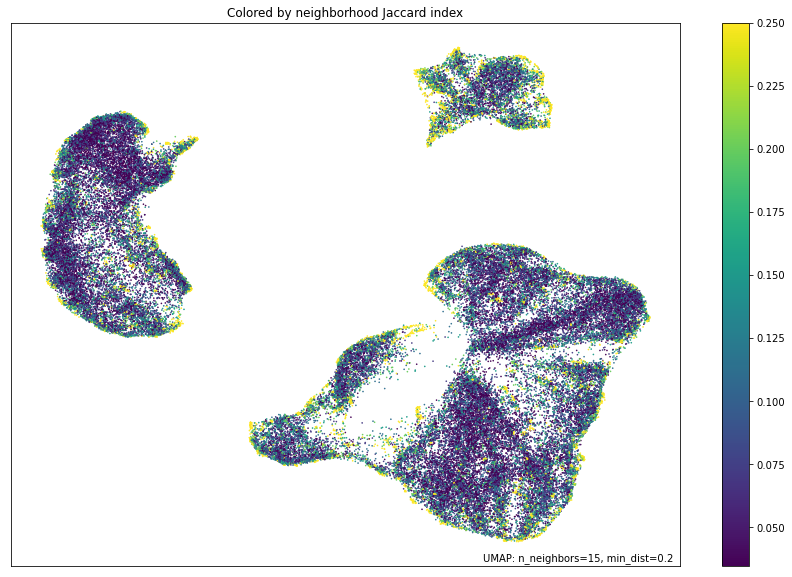

In [18]:
umap.plot.diagnostic(embedding_control_2d, diagnostic_type='neighborhood')

Mon Sep 12 08:20:27 2022 Worst tree score: 0.63642857
Mon Sep 12 08:20:27 2022 Mean tree score: 0.64860794
Mon Sep 12 08:20:27 2022 Best tree score: 0.65645714
Mon Sep 12 08:20:28 2022 Forward diversification reduced edges from 1050000 to 352028
Mon Sep 12 08:20:28 2022 Reverse diversification reduced edges from 352028 to 352028
Mon Sep 12 08:20:28 2022 Degree pruning reduced edges from 386748 to 386216
Mon Sep 12 08:20:28 2022 Resorting data and graph based on tree order
Mon Sep 12 08:20:28 2022 Building and compiling search function


<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

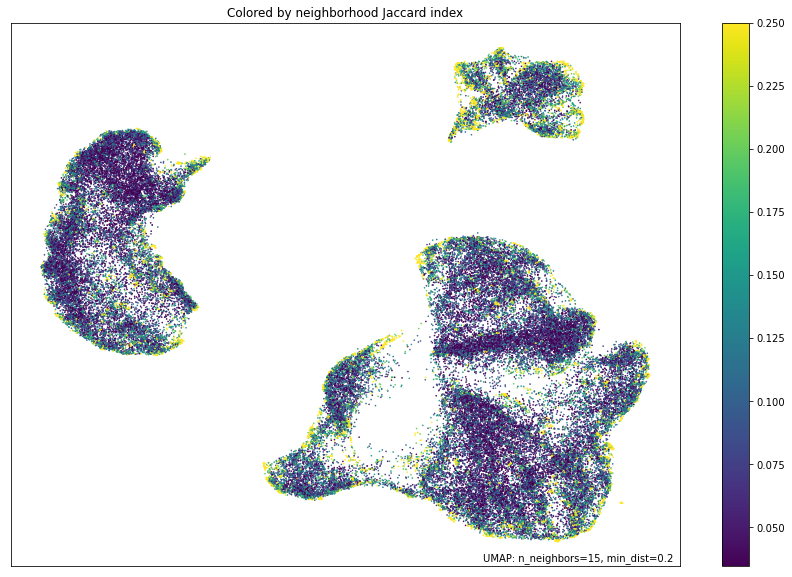

In [19]:
umap.plot.diagnostic(embedding_r200, diagnostic_type='neighborhood')